In [2]:
#descargo los modulos y librerias que se utilizan 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import Muestras2 as ms

# MUESTRAS AMBIENTE

H163-PTB 28
(1,7)
(2,6)
(3,5)


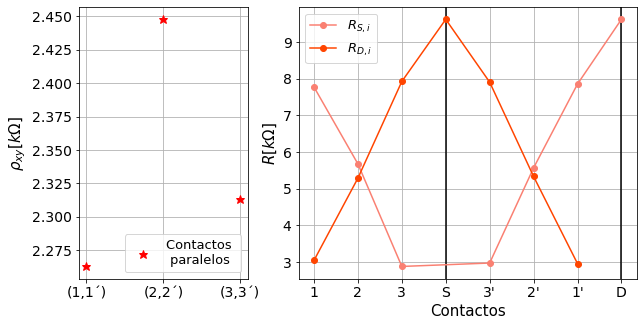

In [3]:
info_muestras = ms.pd.read_excel('data/info_muestras_1.xlsx')

#name = 'PTB-P733-10'
name = 'H163-PTB'
file = f'data/mediciones_amb/{name}.csv' #estoy diciendo que me recorra cada archivo de esa carpeta


row = info_muestras[info_muestras['Nombre'] == name]
muestra_i = ms.Muestra(name, row['Tipo'].iloc[0], row['Anillos'].iloc[0], row['Contactos'].iloc[0], row['Soldaduras'].iloc[0], row['Heater'].iloc[0])
if muestra_i.tipo != 'Circular':
    muestra_i.set_resistencias_mediciones_amb()

    print(name, len(muestra_i.medicion_amb.R['R_avg']))

    if len(muestra_i.medicion_amb.R['R_avg'])>0:
        f, (a0, a1) = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 2]})
        #plot contactos pares
        #f.suptitle(f'{muestra_i.nombre} ambiente',fontsize = 20)
        R_par = []
        x_ticks = []
        for i in range(1,int(muestra_i.contactos/2)):
            j =  int(muestra_i.contactos-i)
            print(f'({i},{j})')
            R_par_i_df = muestra_i.medicion_amb.R.loc[(muestra_i.medicion_amb.R['i']== i) & (muestra_i.medicion_amb.R['j']== j)]
            R_par_i = list(R_par_i_df['R_avg'])
            if len(R_par_i) >0:

                R_par.append(R_par_i[0])
                x_ticks.append(f'({i},{i}´)')
        a0.grid()
        #a0.set_title('Resistencia transversal entre pares',fontsize = 15)
        a0.set(xticks=range(len(R_par)), xticklabels=x_ticks)
        a0.set_ylabel(r'$\rho_{xy}[k\Omega$]',fontsize = 15)
        a0.tick_params(axis='both', labelsize=14)
        
        a0.plot(R_par,'*',color='red',markersize=9,label='Contactos \n paralelos')
        a0.legend(fontsize = 13)
        #plot contactos i contra S y D

        S = int(muestra_i.contactos/2)
        D = int(muestra_i.contactos)

        df_D = muestra_i.medicion_amb.R[(muestra_i.medicion_amb.R['i']== D) | (muestra_i.medicion_amb.R['j']==D)].copy()
        df_S = muestra_i.medicion_amb.R[(muestra_i.medicion_amb.R['i']== S) | (muestra_i.medicion_amb.R['j']==S)].copy()   

        idD = (df_D['j'] == D)
        idS = (df_S['j'] == S)

        df_D.loc[idD,['i','j']] = df_D.loc[idD,['j','i']].values
        df_S.loc[idS,['i','j']] = df_S.loc[idS,['j','i']].values
        
        a1.grid()
        a1.axvline(S,color='black')#label = f'Terminal S: {S}')
        a1.axvline(D,color='black')#label = f'Terminal D: {D}')

        a1.plot(df_S['j'],df_S['R_avg'],'-o',label='$R_{S,i}$',color='salmon')
        a1.plot(df_D['j'],df_D['R_avg'],'-o',label='$R_{D,i}$',color='orangered')

        x_ticks1 = list(range(1,int(muestra_i.contactos/2)))
        x_ticks1_r = x_ticks1.copy()
        x_ticks1_r.reverse()
        x_ticks2 = [f"{i}'" for i in x_ticks1_r]
        x_ticks = x_ticks1 + ['S'] + x_ticks2 + ['D']
        a1.set(xticks=range(1,int(muestra_i.contactos)+1), xticklabels=x_ticks)
        #a1.set_title('Resistencia longitudinal con S y D',fontsize = 15)
        a1.set_ylabel(r'$R[k\Omega$]',fontsize = 15)
        a1.legend(fontsize = 13)
        a1.set_xlabel('Contactos',fontsize = 15)
        a1.tick_params(axis='both', labelsize=14)
    # Create another legend for the second line.
        plt.savefig('PTB-P733-10_plot.jpg', format='jpeg', dpi=500, bbox_inches='tight')


## calculo los errores
utilizo la funcion de la clase muestras porque me esta tirando un error de como esta definida. la arrglare cuando tenga tiemo

In [4]:
def get_error_multimetro(df_e, R_max,R_min,R,rango):
    """
    Esta funcion se usa dentro del metodo del metodo que carga resistencias a 
    temperatura ambiente para asignarle el error a cada medicion.

    """
    #pongo como condicion que para que sea del rango 0< R/Rango <1
    df_error = df_e[((R/df_e['Range'])> 1/1000) & ((R/df_e['Range'])< 1) & (df_e['Range2']== f' {rango}')]
    coefs = list(df_error['1 Year 23°C + 5°C'])[0].split('+')
    m = float(coefs[0])
    b = float(coefs[1])
    c_a = R * m / 100 + b #error aparato
    c_a = 0
    c_b = (R_max - R_min)/np.sqrt(100) #error estadistico
    return c_a + c_b

In [5]:
import Muestras2 as ms

df_error_multimetro = pd.read_csv('data/error_multimetro_R.csv') #pdf del manual
df_rango = pd.read_csv('data/rango.csv') #tengo cargado el rango que utilice para medir cada muestra
rango = list(df_rango[df_rango['nombre'] == muestra_i.nombre]['rango'])[0]
df_R = muestra_i.medicion_amb.R
print(rango) 

errores = []
for i,row in enumerate(df_R.iloc):
    R = float(row['R_avg'])
    R_max = float(row['R_max'])
    R_min = float(row['R_min'])
    #print(R,R_max,R_min)
    e = get_error_multimetro(df_error_multimetro, R_max,R_min,R,rango)
    errores.append(e)
    #print(f'Error: {R} +- {e}')
    
df_R['R_error'] = errores

ko


ko
H163-PTB 28
(1,7)
(2,6)
(3,5)


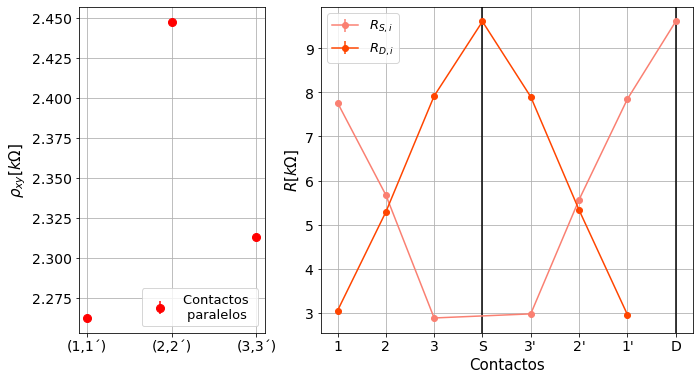

In [8]:
info_muestras = ms.pd.read_excel('data/info_muestras_1.xlsx')

#archivo datos 
#name = 'PTB-P733-10'
name = 'H163-PTB'
file = f'data/mediciones_amb/{name}.csv' #estoy diciendo que me recorra cada archivo de esa carpeta



#archivos errores 
df_error_multimetro = pd.read_csv('data/error_multimetro_R.csv') #pdf del manual
df_rango = pd.read_csv('data/rango.csv') #tengo cargado el rango que utilice para medir cada muestra

print(rango) 


row = info_muestras[info_muestras['Nombre'] == name]
muestra_i = ms.Muestra(name, row['Tipo'].iloc[0], row['Anillos'].iloc[0], row['Contactos'].iloc[0], row['Soldaduras'].iloc[0], row['Heater'].iloc[0])
if muestra_i.tipo != 'Circular':
    muestra_i.set_resistencias_mediciones_amb()

    print(name, len(muestra_i.medicion_amb.R['R_avg']))
    
    
    #seteo error
    rango = list(df_rango[df_rango['nombre'] == muestra_i.nombre]['rango'])[0]
    df_R = muestra_i.medicion_amb.R
    
    errores = []
    for i,row in enumerate(df_R.iloc):
        R = float(row['R_avg'])
        R_max = float(row['R_max'])
        R_min = float(row['R_min'])
        #print(R,R_max,R_min)
        e = get_error_multimetro(df_error_multimetro, R_max,R_min,R,rango)
        errores.append(e)
        #print(f'Error: {R} +- {e}')

    df_R['R_error'] = errores

    #primer plor
    if len(df_R['R_avg'])>0:
        f, (a0, a1) = plt.subplots(1, 2, figsize=(11,6), gridspec_kw={'width_ratios': [1, 2]})
        #plot contactos pares
        #f.suptitle(f'{muestra_i.nombre} ambiente',fontsize = 20)
        R_par = []
        R_par_error = []
        x_ticks = []
        for i in range(1,int(muestra_i.contactos/2)):
            j =  int(muestra_i.contactos-i)
            print(f'({i},{j})')
            R_par_i_df = df_R.loc[(df_R['i']== i) & (df_R['j']== j)]
            R_par_i = list(R_par_i_df['R_avg'])
            R_par_i_error = list(R_par_i_df['R_error'])
            if len(R_par_i) >0:

                R_par.append(R_par_i[0])
                R_par_error.append(R_par_i_error[0])
                x_ticks.append(f'({i},{i}´)')
        a0.grid()
        #a0.set_title('Resistencia transversal entre pares',fontsize = 15)
        a0.set(xticks=range(len(R_par)), xticklabels=x_ticks)
        a0.set_ylabel(r'$\rho_{xy}[k\Omega$]',fontsize = 15)
        a0.tick_params(axis='both', labelsize=14)
        
        #a0.plot(R_par,'*',color='red',markersize=9,label='Contactos \n paralelos')
        a0.errorbar(range(0,3),R_par,fmt='o',color='red',markersize=8,label='Contactos \n paralelos', yerr = R_par_error)
        a0.legend(fontsize = 13)
        
        , fmt=”, ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None, **kwargs)
        
        #plot contactos i contra S y D
        S = int(muestra_i.contactos/2)
        D = int(muestra_i.contactos)

        df_D = df_R[(df_R['i']== D) | (df_R['j']==D)].copy()
        df_S = df_R[(df_R['i']== S) | (df_R['j']==S)].copy()   

        idD = (df_D['j'] == D)
        idS = (df_S['j'] == S)

        df_D.loc[idD,['i','j']] = df_D.loc[idD,['j','i']].values
        df_S.loc[idS,['i','j']] = df_S.loc[idS,['j','i']].values
        
        a1.grid()
        a1.axvline(S,color='black')#label = f'Terminal S: {S}')
        a1.axvline(D,color='black')#label = f'Terminal D: {D}')

        #a1.plot(df_S['j'],df_S['R_avg'],'-o',label='$R_{S,i}$',color='salmon')
        a1.errorbar(df_S['j'],df_S['R_avg'],fmt='-o',label='$R_{S,i}$',color='salmon', yerr = df_S['R_error'])
        a1.errorbar(df_D['j'],df_D['R_avg'],fmt='-o',label='$R_{D,i}$',color='orangered', yerr = df_D['R_error'])
        #a1.plot(df_D['j'],df_D['R_avg'],'-o',label='$R_{D,i}$',color='orangered')

        x_ticks1 = list(range(1,int(muestra_i.contactos/2)))
        x_ticks1_r = x_ticks1.copy()
        x_ticks1_r.reverse()
        x_ticks2 = [f"{i}'" for i in x_ticks1_r]
        x_ticks = x_ticks1 + ['S'] + x_ticks2 + ['D']
        a1.set(xticks=range(1,int(muestra_i.contactos)+1), xticklabels=x_ticks)
        #a1.set_title('Resistencia longitudinal con S y D',fontsize = 15)
        a1.set_ylabel(r'$R[k\Omega$]',fontsize = 15)
        a1.legend(fontsize = 13)
        a1.set_xlabel('Contactos',fontsize = 15)
        a1.tick_params(axis='both', labelsize=14)
    # Create another legend for the second line.
        plt.savefig(f'{name}_plot.jpg', format='jpeg', dpi=500, bbox_inches='tight')


# MUESTRAS NITROGENO

ko
PTB-P733-10 28
(1,7)
(2,6)
(3,5)


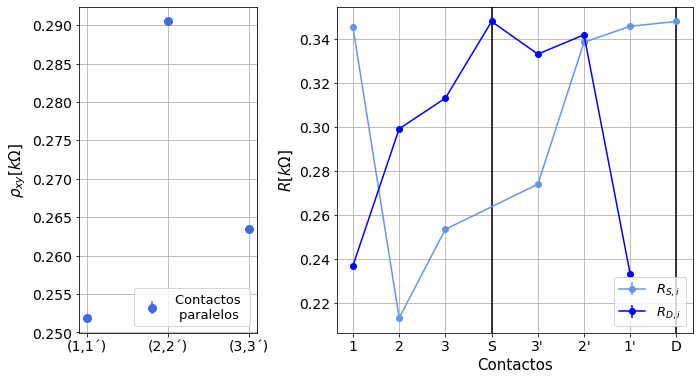

In [84]:
info_muestras = ms.pd.read_excel('data/info_muestras_1.xlsx')

#archivo datos R
file = 'data/mediciones_nit/PTB-P733-10.csv' #estoy diciendo que me recorra cada archivo de esa carpeta
name = 'PTB-P733-10'


#archivos errores 
df_error_multimetro = pd.read_csv('data/error_multimetro_R.csv') #pdf del manual
df_rango = pd.read_csv('data/rango.csv') #tengo cargado el rango que utilice para medir cada muestra

print(rango) 


row = info_muestras[info_muestras['Nombre'] == name]
muestra_i = ms.Muestra(name, row['Tipo'].iloc[0], row['Anillos'].iloc[0], row['Contactos'].iloc[0], row['Soldaduras'].iloc[0], row['Heater'].iloc[0])
if muestra_i.tipo != 'Circular':
    muestra_i.set_resistencias_mediciones_nit()

    print(name, len(muestra_i.medicion_nit.R['R_avg']))
    
    
    #seteo error
    rango = list(df_rango[df_rango['nombre'] == muestra_i.nombre]['rango'])[0]
    df_R = muestra_i.medicion_nit.R
    
    errores = []
    for i,row in enumerate(df_R.iloc):
        R = float(row['R_avg'])
        R_max = float(row['R_max'])
        R_min = float(row['R_min'])
        #print(R,R_max,R_min)
        e = get_error_multimetro(df_error_multimetro, R_max,R_min,R,rango)
        errores.append(e)
        #print(f'Error: {R} +- {e}')

    df_R['R_error'] = errores

    #primer plor
    if len(df_R['R_avg'])>0:
        f, (a0, a1) = plt.subplots(1, 2, figsize=(11,6), gridspec_kw={'width_ratios': [1, 2]})
        plt.subplots_adjust( wspace=0.3)
        #plot contactos pares
        #f.suptitle(f'{muestra_i.nombre} ambiente',fontsize = 20)
        R_par = []
        R_par_error = []
        x_ticks = []
        for i in range(1,int(muestra_i.contactos/2)):
            j =  int(muestra_i.contactos-i)
            print(f'({i},{j})')
            R_par_i_df = df_R.loc[(df_R['i']== i) & (df_R['j']== j)]
            R_par_i = list(R_par_i_df['R_avg'])
            R_par_i_error = list(R_par_i_df['R_error'])
            if len(R_par_i) >0:

                R_par.append(R_par_i[0])
                R_par_error.append(R_par_i_error[0])
                x_ticks.append(f'({i},{i}´)')
        a0.grid()
        #a0.set_title('Resistencia transversal entre pares',fontsize = 15)
        a0.set(xticks=range(len(R_par)), xticklabels=x_ticks)
        a0.set_ylabel(r'$\rho_{xy}[k\Omega$]',fontsize = 15)
        a0.tick_params(axis='both', labelsize=14)
        
        #a0.plot(R_par,'*',color='red',markersize=9,label='Contactos \n paralelos')
        a0.errorbar(range(0,3),R_par,fmt='o',color='royalblue',markersize=8,label='Contactos \n paralelos', yerr = R_par_error)
        a0.legend(fontsize = 13)
        
        , fmt=”, ecolor=None, elinewidth=None, capsize=None, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, *, data=None, **kwargs)
        
        #plot contactos i contra S y D
        S = int(muestra_i.contactos/2)
        D = int(muestra_i.contactos)

        df_D = df_R[(df_R['i']== D) | (df_R['j']==D)].copy()
        df_S = df_R[(df_R['i']== S) | (df_R['j']==S)].copy()   

        idD = (df_D['j'] == D)
        idS = (df_S['j'] == S)

        df_D.loc[idD,['i','j']] = df_D.loc[idD,['j','i']].values
        df_S.loc[idS,['i','j']] = df_S.loc[idS,['j','i']].values
        
        a1.grid()
        a1.axvline(S,color='black')#label = f'Terminal S: {S}')
        a1.axvline(D,color='black')#label = f'Terminal D: {D}')

        #a1.plot(df_S['j'],df_S['R_avg'],'-o',label='$R_{S,i}$',color='salmon')
        a1.errorbar(df_S['j'],df_S['R_avg'],fmt='-o',label='$R_{S,i}$',color='cornflowerblue', yerr = df_S['R_error'])
        a1.errorbar(df_D['j'],df_D['R_avg'],fmt='-o',label='$R_{D,i}$',color='blue', yerr = df_D['R_error'])
        #a1.plot(df_D['j'],df_D['R_avg'],'-o',label='$R_{D,i}$',color='orangered')

        x_ticks1 = list(range(1,int(muestra_i.contactos/2)))
        x_ticks1_r = x_ticks1.copy()
        x_ticks1_r.reverse()
        x_ticks2 = [f"{i}'" for i in x_ticks1_r]
        x_ticks = x_ticks1 + ['S'] + x_ticks2 + ['D']
        a1.set(xticks=range(1,int(muestra_i.contactos)+1), xticklabels=x_ticks)
        #a1.set_title('Resistencia longitudinal con S y D',fontsize = 15)
        a1.set_ylabel(r'$R[k\Omega$]',fontsize = 15)
        a1.legend(fontsize = 13)
        a1.set_xlabel('Contactos',fontsize = 15)
        a1.tick_params(axis='both', labelsize=14)
    # Create another legend for the second line.
        plt.savefig('PTB-P733-10_plot.jpg', format='jpeg', dpi=500, bbox_inches='tight')
